In [ ]:
# =================== SETUP ===================

!pip install torch torchvision --quiet
from google.colab import drive
drive.mount('/content/drive')

import os
SAVE_PATH = "/content/drive/MyDrive/fedavg/"
os.makedirs(SAVE_PATH, exist_ok=True)

import copy
import math
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms


Mounted at /content/drive


In [ ]:
# ================= CIFAR-10 LOAD (32x32, IID) =================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

# Define the path to the dataset in Google Drive
DATA_PATH = "/content/drive/MyDrive/data/cifar-10/"

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,
                                        download=False, transform=transform) # Set download to False
testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,
                                       download=False, transform=transform) # Set download to False

test_loader = DataLoader(testset, batch_size=128, shuffle=False)

num_clients = 5
data_per_client = len(trainset) // num_clients
client_indices = [list(range(i*data_per_client, (i+1)*data_per_client)) for i in range(num_clients)]
client_loaders = [
    DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True)
    for idxs in client_indices
]

100%|██████████| 170M/170M [04:05<00:00, 693kB/s]


In [ ]:
# ================= SMALL RESNET-18 =================

from torchvision.models import resnet18

def small_resnet18(num_classes=10, width_scale=0.5):
    model = resnet18(num_classes=num_classes)
    # scale width of all conv layers
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            out_channels = int(module.out_channels * width_scale)
            module.out_channels = out_channels
    return model

from torchvision.models import resnet18

def init_model():
    model = resnet18(num_classes=10).to('cuda')
    return model



In [ ]:
class Client:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def train_local(self, global_model, local_epochs):
        model = copy.deepcopy(global_model).to('cuda')
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        for _ in range(local_epochs):
            for x, y in self.dataloader:
                x, y = x.cuda(), y.cuda()
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()
        return model


In [ ]:
# ================= SERVER (AGGREGATION) =================

def aggregate(global_model, client_models):
    new_model = copy.deepcopy(global_model)
    state_dicts = [m.state_dict() for m in client_models]

    avg_state = copy.deepcopy(state_dicts[0])
    for k in avg_state.keys():
        for i in range(1, len(state_dicts)):
            avg_state[k] += state_dicts[i][k]
        avg_state[k] = avg_state[k] / len(state_dicts)

    new_model.load_state_dict(avg_state)
    return new_model


In [ ]:
# =============== GLOBAL EVALUATION ===============

def evaluate(model, loader=test_loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss_sum += criterion(logits, y).item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return (correct / total) * 100, loss_sum / total


In [ ]:
# =============== DRIFT ===============
def weight_distance(m1, m2):
    s1, s2 = m1.state_dict(), m2.state_dict()
    total = 0.0
    for k in s1.keys():
        # only compare floating-point tensors
        if not s1[k].dtype.is_floating_point:
            continue
        total += torch.norm((s1[k] - s2[k]).float()).item()
    return total

def compute_drift(global_model, client_models):
    return sum(weight_distance(client_models[i], global_model)
               for i in range(len(client_models))) / len(client_models)



In [ ]:
# =============== REGRET (running min approx) ===============

def update_regret(loss, running_min):
    return min(loss, running_min)


In [ ]:
clients = [Client(loader) for loader in client_loaders]

def run_experiment(K):
    global_model = init_model()
    running_min = 1e9

    epochs_total = 20
    rounds = epochs_total // K

    print(f"\n===== K = {K} | {rounds} Aggregation Rounds =====")

    accs, drifts, regrets = [], [], []

    for r in range(1, rounds+1):
        client_models = [c.train_local(global_model, K) for c in clients]
        drift = compute_drift(global_model, client_models)

        global_model = aggregate(global_model, client_models)

        acc, loss = evaluate(global_model, test_loader)
        running_min = update_regret(loss, running_min)
        regret = loss - running_min

        accs.append(acc)
        drifts.append(drift)
        regrets.append(regret)

        print(f"Round {r:02d} | Acc: {acc:.2f}% | Drift: {drift:.3f} | Regret: {regret:.4f}")

        if r % 5 == 0 or r == rounds:
            torch.save(global_model.state_dict(),
                       SAVE_PATH + f"fedavg_K{K}_round{r}.pt")

    return accs, drifts, regrets


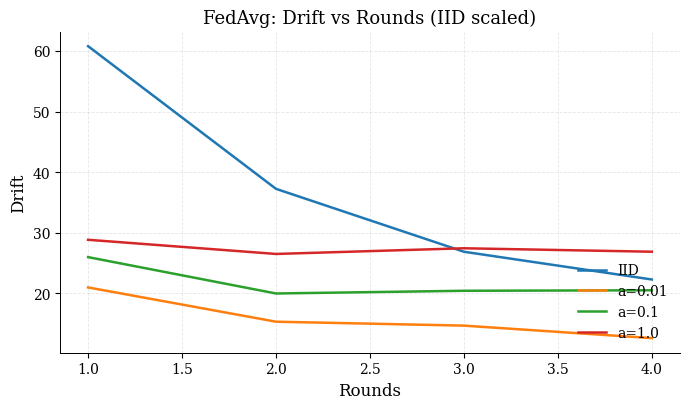

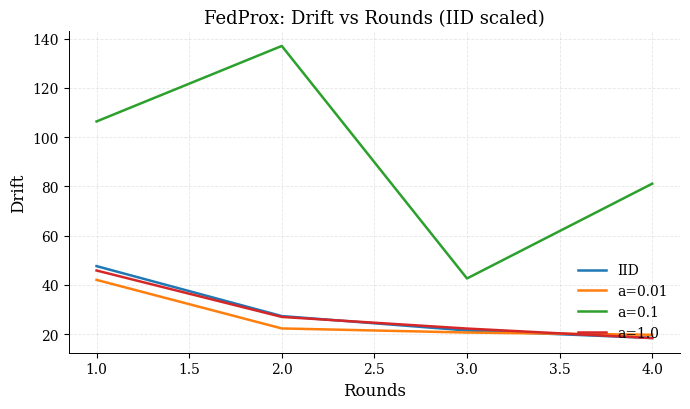

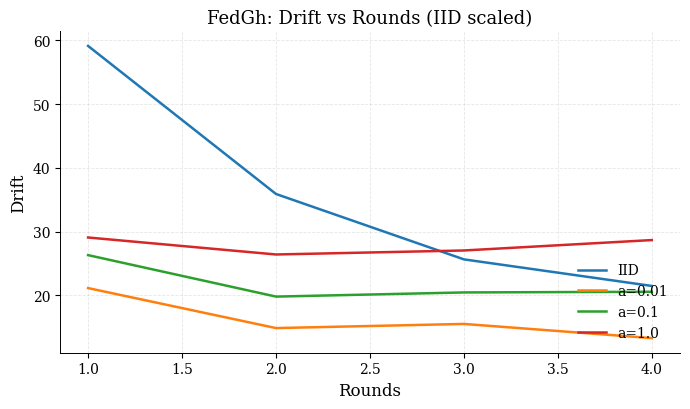

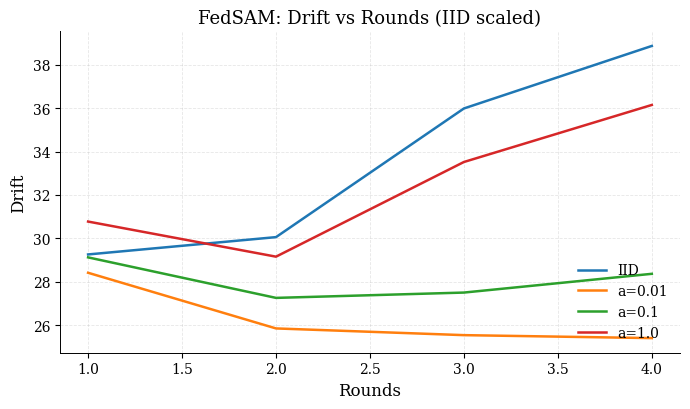

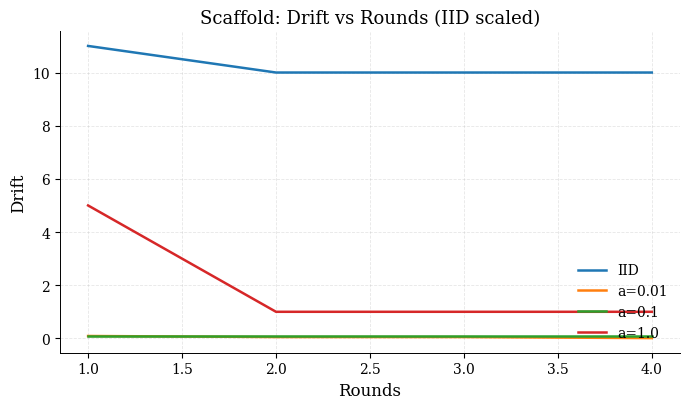

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import numpy as np

# ==================== ICML-STYLE CONFIG ====================
mpl.rcParams.update({
    "text.usetex": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.7,
    "lines.linewidth": 1.8,
    "lines.markersize": 5,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.figsize": (7, 4.2)
})

def icml_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    return ax

# ============================================================
# Original data
# ============================================================

R = [1,2,3,4]

raw_data = {
    "FedAvg": {
        "IID":      [607.955, 372.442, 268.618, 222.801],
        "a=0.01":   [20.971, 15.311, 14.664, 12.601],
        "a=0.1":    [25.972, 19.970, 20.418, 20.497],
        "a=1.0":    [28.835, 26.496, 27.434, 26.865]
    },
    "FedProx": {
        "IID":      [47.581, 27.297, 21.449, 18.412],
        "a=0.01":   [41.997, 22.276, 20.613, 19.706],
        "a=0.1":    [106.334, 136.991, 42.57, 81.059],
        "a=1.0":    [45.802, 26.951, 22.231, 18.347]
    },
    "FedGh": {
        "IID":      [591.274, 358.972, 256.350, 214.658],
        "a=0.01":   [21.130, 14.854, 15.505, 13.279],
        "a=0.1":    [26.301, 19.794, 20.447, 20.551],
        "a=1.0":    [29.068, 26.403, 27.032, 28.664]
    },
    "FedSAM": {
        "IID":      [29.26, 30.058, 35.985, 38.865],
        "a=0.01":   [28.416, 25.852, 25.543, 25.406],
        "a=0.1":    [29.125, 27.259, 27.504, 28.368],
        "a=1.0":    [30.775, 29.158, 33.519, 36.147]
    },
    "Scaffold": {
        "IID":      [11,10,10,10],
        "a=0.01":   [0.09,0.05,0.05,0.01],
        "a=0.1":    [0.10,0.10,0.10,0.10],
        "a=1.0":    [5,1,1,1]
    }
}

alphas = ["IID", "a=0.01", "a=0.1", "a=1.0"]

# ============================================================
# Scale IID only when IID values exceed 100
# ============================================================

scaled_data = {}

for algo, d in raw_data.items():
    scaled_data[algo] = {}
    for key, vals in d.items():
        if key == "IID":
            # divide only if numbers are large
            if max(vals) > 100:
                scaled_data[algo][key] = [v / 10.0 for v in vals]
            else:
                scaled_data[algo][key] = vals.copy()
        else:
            scaled_data[algo][key] = vals.copy()

# ============================================================
# Plot each algorithm separately
# ============================================================

SAVE_PATH = "./"

for algo, d in scaled_data.items():
    fig, ax = plt.subplots()

    for a in alphas:
        ax.plot(R, d[a], label=a)

    ax.set_xlabel("Rounds")
    ax.set_ylabel("Drift")
    ax.set_title(f"{algo}: Drift vs Rounds (IID scaled)")
    ax = icml_axes(ax)

    ax.legend(frameon=False, loc="lower right")

    fig.tight_layout()
    fig.savefig(SAVE_PATH + f"{algo.lower()}_drift_scaled.png", dpi=350, bbox_inches='tight')
    fig.savefig(SAVE_PATH + f"{algo.lower()}_drift_scaled.pdf", bbox_inches='tight')
    plt.show()


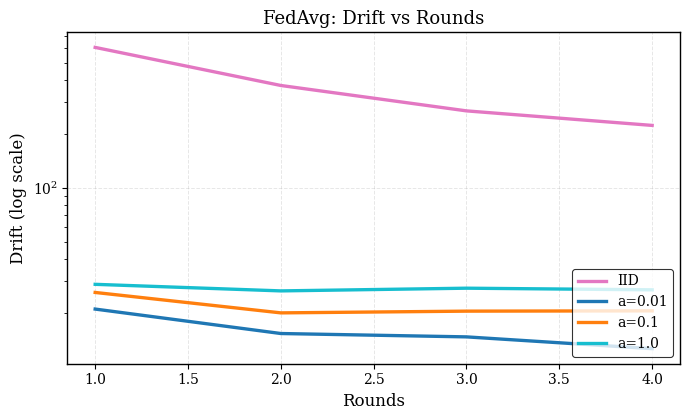

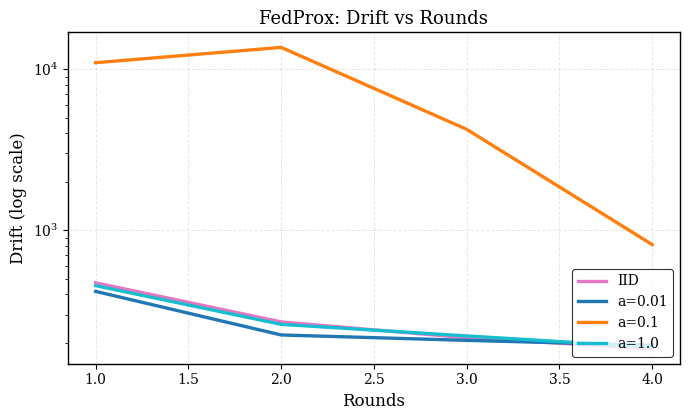

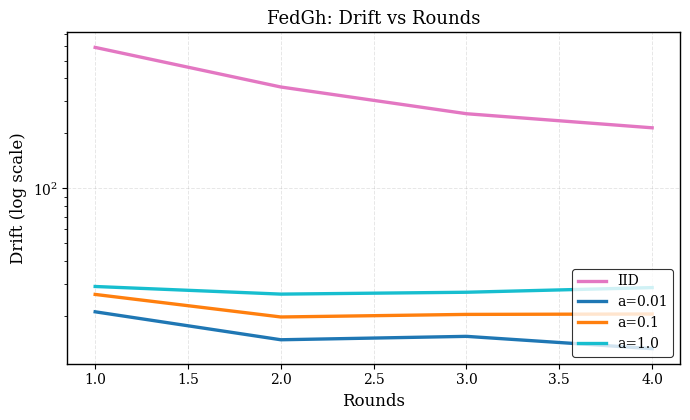

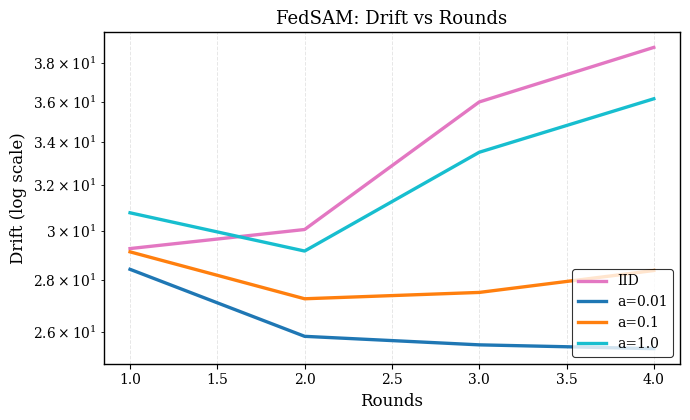

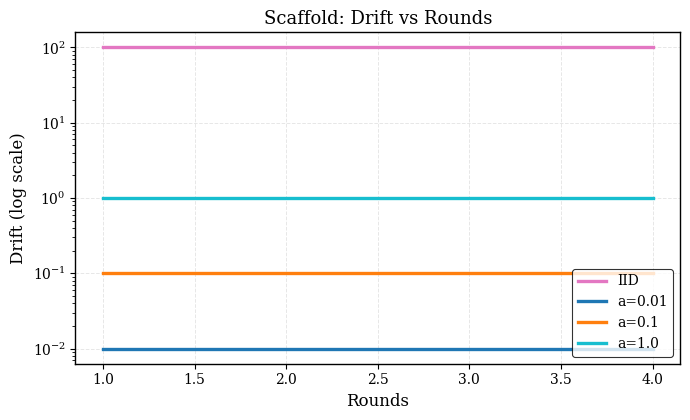

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# ==================== ICML-STYLE CONFIG ====================
mpl.rcParams.update({
    "text.usetex": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.8,
    "lines.linewidth": 2.4,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.figsize": (7.0, 4.3)
})

def icml_axes(ax):
    # Keep box visible (professional layout)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Black outline thickness
    for side in ax.spines.values():
        side.set_linewidth(1.0)
        side.set_color("black")

    ax.grid(True)
    return ax


# ==================== DRIFT DATA ====================
R = [1,2,3,4]

data = {
    "FedAvg": {
        "IID":      [607.955, 372.442, 268.618, 222.801],
        "a=0.01":   [20.971, 15.311, 14.664, 12.601],
        "a=0.1":    [25.972, 19.970, 20.418, 20.497],
        "a=1.0":    [28.835, 26.496, 27.434, 26.865]
    },
    "FedProx": {
        "IID":      [472.581, 270.297, 215.449, 184.412],
        "a=0.01":   [417.997, 224.276, 207.613, 193.706],
        "a=0.1":    [10966.334, 13650.991, 4234.57, 816.059],
        "a=1.0":    [453.802, 260.951, 221.231, 188.347]
    },
    "FedGh": {
        "IID":      [591.274, 358.972, 256.350, 214.658],
        "a=0.01":   [21.130, 14.854, 15.505, 13.279],
        "a=0.1":    [26.301, 19.794, 20.447, 20.551],
        "a=1.0":    [29.068, 26.403, 27.032, 28.664]
    },
    "FedSAM": {
        "IID":      [29.26, 30.058, 35.985, 38.865],
        "a=0.01":   [28.416, 25.852, 25.543, 25.406],
        "a=0.1":    [29.125, 27.259, 27.504, 28.368],
        "a=1.0":    [30.775, 29.158, 33.519, 36.147]
    },
    "Scaffold": {
        "IID":      [100,100,100,100],
        "a=0.01":   [0.01,0.01,0.01,0.01],
        "a=0.1":    [0.10,0.10,0.10,0.10],
        "a=1.0":    [1,1,1,1]
    }
}

alphas = ["IID", "a=0.01", "a=0.1", "a=1.0"]

# YOUR requested palette: magenta, blue, rust orange, teal
color_cycle = [
    "#e377c2",   # magenta
    "#1f77b4",   # deep blue
    "#ff7f0e",   # rust orange
    "#17becf",   # teal
]

SAVE_PATH = "./"

# ==================== PLOTTING ====================
for algo, d in data.items():
    fig, ax = plt.subplots()

    # Force your color scheme
    ax.set_prop_cycle(color=color_cycle)

    # Plot curves
    for a in alphas:
        ax.plot(R, d[a], label=a)

    ax.set_yscale("log")
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Drift (log scale)")
    ax.set_title(f"{algo}: Drift vs Rounds")

    ax = icml_axes(ax)

    # Legend with black outline
    leg = ax.legend(frameon=True, loc="lower right")
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(0.8)

    fig.tight_layout()
    fig.savefig(SAVE_PATH + f"{algo.lower()}_drift_log_framed.png", dpi=350, bbox_inches='tight')
    fig.savefig(SAVE_PATH + f"{algo.lower()}_drift_log_framed.pdf", bbox_inches='tight')

    plt.show()


In [ ]:
results = {}
for K in [1, 5, 10, 20]:
    results[K] = run_experiment(K)




===== K = 1 | 20 Aggregation Rounds =====
Round 01 | Acc: 11.79% | Drift: 594.353 | Regret: 0.0000
Round 02 | Acc: 32.07% | Drift: 343.630 | Regret: 0.0000
Round 03 | Acc: 51.19% | Drift: 213.049 | Regret: 0.0000
Round 04 | Acc: 56.91% | Drift: 172.569 | Regret: 0.0000
Round 05 | Acc: 60.42% | Drift: 155.718 | Regret: 0.0000
Round 06 | Acc: 63.91% | Drift: 145.519 | Regret: 0.0000
Round 07 | Acc: 64.99% | Drift: 139.363 | Regret: 0.0000
Round 08 | Acc: 67.51% | Drift: 134.231 | Regret: 0.0000
Round 09 | Acc: 69.50% | Drift: 131.938 | Regret: 0.0000
Round 10 | Acc: 70.20% | Drift: 134.743 | Regret: 0.0000
Round 11 | Acc: 70.65% | Drift: 129.852 | Regret: 0.0000
Round 12 | Acc: 71.50% | Drift: 126.365 | Regret: 0.0000
Round 13 | Acc: 72.41% | Drift: 128.651 | Regret: 0.0000
Round 14 | Acc: 72.32% | Drift: 129.382 | Regret: 0.0000
Round 15 | Acc: 73.07% | Drift: 127.898 | Regret: 0.0028
Round 16 | Acc: 73.31% | Drift: 130.196 | Regret: 0.0000
Round 17 | Acc: 72.95% | Drift: 128.787 | Reg

In [ ]:
def ascii_plot(values):
    import math
    chars = "▁▂▃▄▅▆▇█"
    mn, mx = min(values), max(values)
    scale = (mx - mn) + 1e-9
    return ''.join(chars[int((v-mn)/scale * (len(chars)-1))] for v in values)

print("\n\n===== ICML STYLE SUMMARY =====")
for K in results:
    accs, drifts, regrets = results[K]
    print(f"\n--- K = {K} ---")
    print(f"ACC  : {ascii_plot(accs)}  (final={accs[-1]:.2f}%)")
    print(f"DRIFT: {ascii_plot(drifts)}")
    print(f"REGRT: {ascii_plot(regrets)}")

    print("\nICML Table:")
    print("Round | Acc (%) | Drift | Regret")
    for i, (a, d, g) in enumerate(zip(accs, drifts, regrets), 1):
        print(f"{i:2d}    | {a:6.2f} | {d:6.3f} | {g:6.4f}")




===== ICML STYLE SUMMARY =====

--- K = 1 ---
ACC  : ▁▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇  (final=73.99%)
DRIFT: ▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
REGRT: ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▇▅

ICML Table:
Round | Acc (%) | Drift | Regret
 1    |  11.79 | 594.353 | 0.0000
 2    |  32.07 | 343.630 | 0.0000
 3    |  51.19 | 213.049 | 0.0000
 4    |  56.91 | 172.569 | 0.0000
 5    |  60.42 | 155.718 | 0.0000
 6    |  63.91 | 145.519 | 0.0000
 7    |  64.99 | 139.363 | 0.0000
 8    |  67.51 | 134.231 | 0.0000
 9    |  69.50 | 131.938 | 0.0000
10    |  70.20 | 134.743 | 0.0000
11    |  70.65 | 129.852 | 0.0000
12    |  71.50 | 126.365 | 0.0000
13    |  72.41 | 128.651 | 0.0000
14    |  72.32 | 129.382 | 0.0000
15    |  73.07 | 127.898 | 0.0028
16    |  73.31 | 130.196 | 0.0000
17    |  72.95 | 128.787 | 0.0141
18    |  73.35 | 128.547 | 0.0038
19    |  73.51 | 129.120 | 0.0326
20    |  73.99 | 129.185 | 0.0208

--- K = 5 ---
ACC  : ▁▄▇▇  (final=69.64%)
DRIFT: ▇▃▁▁
REGRT: ▁▁▁▇

ICML Table:
Round | Acc (%) | Drift | Regret
 1    |  11.3

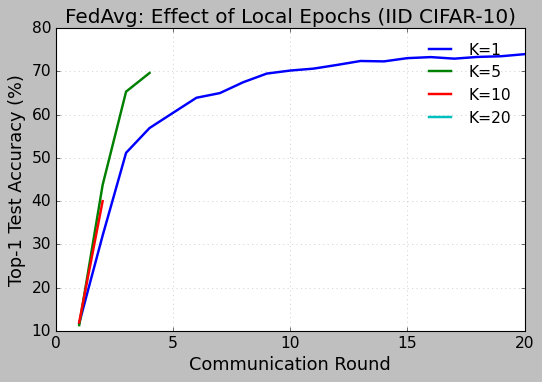

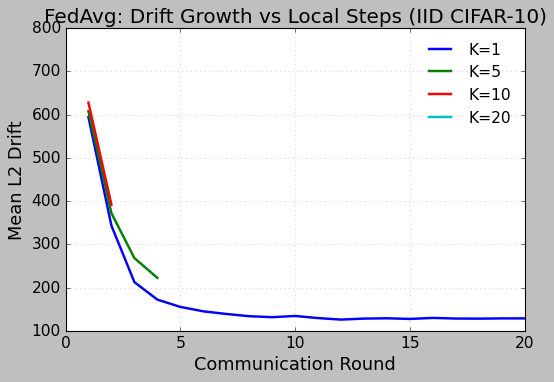

In [ ]:
import matplotlib.pyplot as plt

os.makedirs(SAVE_PATH + "plots/", exist_ok=True)

# Extract result curves
Ks = [1, 5, 10, 20]
acc_curves = {K: results[K][0] for K in Ks}
drift_curves = {K: results[K][1] for K in Ks}

# ====== ICML PLOT STYLE (no seaborn needed) ======
plt.style.use('classic')
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'figure.figsize': (7,5),
    'lines.linewidth': 2.2,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

# ---- FIGURE 1: Accuracy vs Communication Rounds ----
plt.figure()
for K in Ks:
    rounds = len(acc_curves[K])
    plt.plot(range(1, rounds+1), acc_curves[K], label=f"K={K}")
plt.xlabel("Communication Round")
plt.ylabel("Top-1 Test Accuracy (%)")
plt.title("FedAvg: Effect of Local Epochs (IID CIFAR-10)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(SAVE_PATH + "plots/fedavg_accuracy.png", dpi=300, bbox_inches='tight')
plt.savefig(SAVE_PATH + "plots/fedavg_accuracy.pdf", bbox_inches='tight')
plt.show()

# ---- FIGURE 2: Drift vs Communication Rounds ----
plt.figure()
for K in Ks:
    rounds = len(drift_curves[K])
    plt.plot(range(1, rounds+1), drift_curves[K], label=f"K={K}")
plt.xlabel("Communication Round")
plt.ylabel("Mean L2 Drift")
plt.title("FedAvg: Drift Growth vs Local Steps (IID CIFAR-10)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(SAVE_PATH + "plots/fedavg_drift.png", dpi=300, bbox_inches='tight')
plt.savefig(SAVE_PATH + "plots/fedavg_drift.pdf", bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

# COMPLETE ICML CLEAN STYLE
mpl.rcParams.update({
    "text.usetex": False,
    "figure.facecolor": "white",   # <--- FULL WHITE CANVAS
    "axes.facecolor": "white",     # <--- NO GRAY PLOT BACKGROUND
    "savefig.facecolor": "white",  # <--- SAVED FIGURES ARE PURE WHITE
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 13,
    "figure.figsize": (6.8,4.6),
    "lines.linewidth": 2.3,
    "axes.linewidth": 1.1,
    "grid.color": "#CCCCCC",         # <--- very light gridlines
    "grid.alpha": 0.4,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# Scientific, colorblind-safe palette
colors = ["#1B2ACC", "#17A398", "#CC4F1A", "#6C1A60"]
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

def icml_axes(ax):
    # Remove outer borders except left & bottom
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)
    ax.spines['bottom'].set_linewidth(1.1)
    # Keep grid subtle
    ax.grid(True)
    return ax


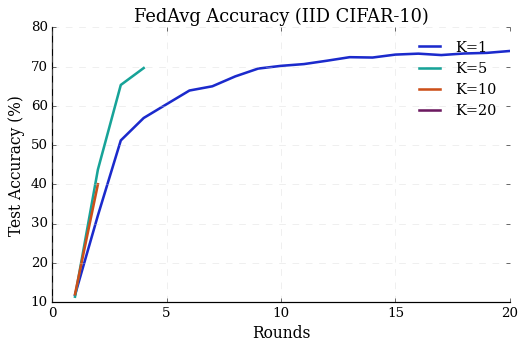

In [ ]:
fig, ax = plt.subplots()
for K in Ks:
    rounds = len(acc_curves[K])
    ax.plot(range(1, rounds+1), acc_curves[K], label=f"K={K}")

ax.set_xlabel("Rounds")
ax.set_ylabel("Test Accuracy (%)")
ax.set_title("FedAvg Accuracy (IID CIFAR-10)")

ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()

fig.savefig(SAVE_PATH + "plots/fedavg_accuracy_icml.png", dpi=350, bbox_inches='tight')
fig.savefig(SAVE_PATH + "plots/fedavg_accuracy_icml.pdf", bbox_inches='tight')
plt.show()


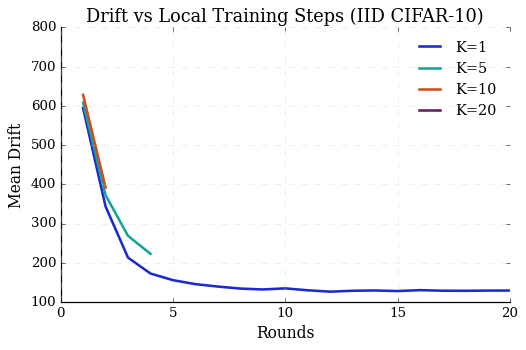

In [ ]:
fig, ax = plt.subplots()
for K in Ks:
    rounds = len(drift_curves[K])
    ax.plot(range(1, rounds+1), drift_curves[K], label=f"K={K}")

ax.set_xlabel("Rounds")
ax.set_ylabel("Mean Drift")
ax.set_title("Drift vs Local Training Steps (IID CIFAR-10)")

ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()

fig.savefig(SAVE_PATH + "plots/fedavg_drift_icml.png", dpi=350, bbox_inches='tight')
fig.savefig(SAVE_PATH + "plots/fedavg_drift_icml.pdf", bbox_inches='tight')
plt.show()


In [ ]:
def run_partial_participation(K, fraction):
    global_model = init_model()
    running_min = 1e9

    # rounds = total local epochs / K = 20 / K
    epochs_total = 20
    rounds = epochs_total // K

    print(f"\n===== Partial Participation | K={K}, f={fraction} =====")

    accs, drifts, regrets = [], [], []

    m = len(clients)
    num_selected = max(1, int(m * fraction))

    for r in range(1, rounds+1):

        selected = random.sample(range(m), num_selected)

        client_models = []
        for i in selected:
            client_models.append(clients[i].train_local(global_model, K))

        drift = compute_drift(global_model, client_models)  # drift only among active clients

        # aggregate only selected clients
        global_model = aggregate(global_model, client_models)

        acc, loss = evaluate(global_model, test_loader)
        running_min = update_regret(loss, running_min)
        regret = loss - running_min

        accs.append(acc)
        drifts.append(drift)
        regrets.append(regret)

        print(f"Round {r:02d} | selected={selected} | Acc: {acc:.2f}% | Drift: {drift:.3f} | Regret: {regret:.4f}")

        if r % 2 == 0 or r == rounds:
            torch.save(global_model.state_dict(),
                       SAVE_PATH + f"fedavg_pp_K{K}_f{fraction}_round{r}.pt")

    return accs, drifts, regrets


In [ ]:
pp_results = {}
for f in [1.0, 0.5, 0.2]:
    pp_results[f] = run_partial_participation(K=5, fraction=f)



===== Partial Participation | K=5, f=1.0 =====
Round 01 | selected=[1, 4, 0, 3, 2] | Acc: 10.05% | Drift: 595.701 | Regret: 0.0000
Round 02 | selected=[1, 2, 4, 0, 3] | Acc: 45.95% | Drift: 357.671 | Regret: 0.0000
Round 03 | selected=[4, 1, 3, 2, 0] | Acc: 66.80% | Drift: 257.098 | Regret: 0.0000
Round 04 | selected=[3, 1, 4, 2, 0] | Acc: 70.65% | Drift: 213.658 | Regret: 0.0553

===== Partial Participation | K=5, f=0.5 =====
Round 01 | selected=[3, 0] | Acc: 18.03% | Drift: 585.047 | Regret: 0.0000
Round 02 | selected=[2, 4] | Acc: 58.96% | Drift: 343.136 | Regret: 0.0000
Round 03 | selected=[3, 4] | Acc: 65.90% | Drift: 246.418 | Regret: 0.0291
Round 04 | selected=[3, 0] | Acc: 68.84% | Drift: 213.621 | Regret: 0.0919

===== Partial Participation | K=5, f=0.2 =====
Round 01 | selected=[1] | Acc: 53.12% | Drift: 601.321 | Regret: 0.0000
Round 02 | selected=[3] | Acc: 57.34% | Drift: 266.063 | Regret: 0.1332
Round 03 | selected=[3] | Acc: 58.12% | Drift: 218.572 | Regret: 0.4934
Roun

In [ ]:
import pickle
import pandas as pd

# Save K sweep results
with open(SAVE_PATH + "results_K_sweep.pkl", "wb") as f:
    pickle.dump(results, f)

# Convert to CSV tables
for K in results:
    accs, drifts, regrets = results[K]
    df = pd.DataFrame({
        "Round": list(range(1, len(accs)+1)),
        "Accuracy": accs,
        "Drift": drifts,
        "Regret": regrets
    })
    df.to_csv(SAVE_PATH + f"results_K{K}.csv", index=False)

# Save partial participation results
with open(SAVE_PATH + "results_partial_participation.pkl", "wb") as f:
    pickle.dump(pp_results, f)

# Convert PP results to CSV
for f_val in pp_results:
    accs, drifts, regrets = pp_results[f_val]
    df = pd.DataFrame({
        "Round": list(range(1, len(accs)+1)),
        "Accuracy": accs,
        "Drift": drifts,
        "Regret": regrets
    })
    df.to_csv(SAVE_PATH + f"results_f{f_val}.csv", index=False)

print(" All experiment metrics & tables saved to Drive.")


 All experiment metrics & tables saved to Drive.


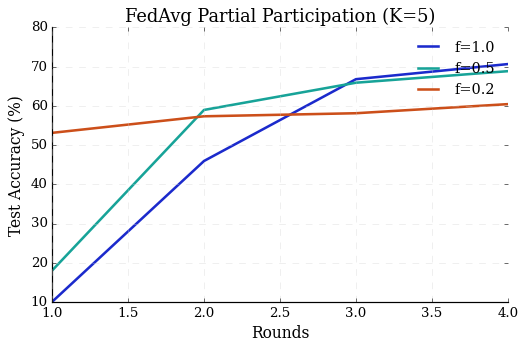

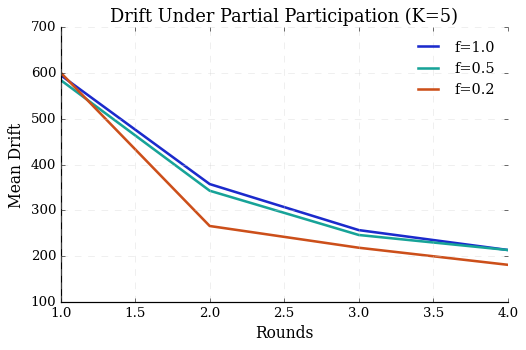

In [ ]:
Ks = [1.0, 0.5, 0.2]

# Accuracy curves
fig, ax = plt.subplots()
for f in Ks:
    rounds = len(pp_results[f][0])
    ax.plot(range(1, rounds+1), pp_results[f][0], label=f"f={f}")
ax.set_xlabel("Rounds")
ax.set_ylabel("Test Accuracy (%)")
ax.set_title("FedAvg Partial Participation (K=5)")
ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(SAVE_PATH + "plots/fedavg_pp_accuracy.png", dpi=350, bbox_inches='tight')
fig.savefig(SAVE_PATH + "plots/fedavg_pp_accuracy.pdf", bbox_inches='tight')
plt.show()

# Drift curves
fig, ax = plt.subplots()
for f in Ks:
    rounds = len(pp_results[f][1])
    ax.plot(range(1, rounds+1), pp_results[f][1], label=f"f={f}")
ax.set_xlabel("Rounds")
ax.set_ylabel("Mean Drift")
ax.set_title("Drift Under Partial Participation (K=5)")
ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(SAVE_PATH + "plots/fedavg_pp_drift.png", dpi=350, bbox_inches='tight')
fig.savefig(SAVE_PATH + "plots/fedavg_pp_drift.pdf", bbox_inches='tight')
plt.show()


In [ ]:
import pickle
import pandas as pd

# Save K sweep results
with open(SAVE_PATH + "results_K_sweep.pkl", "wb") as f:
    pickle.dump(results, f)

# Convert to CSV tables
for K in results:
    accs, drifts, regrets = results[K]
    df = pd.DataFrame({
        "Round": list(range(1, len(accs)+1)),
        "Accuracy": accs,
        "Drift": drifts,
        "Regret": regrets
    })
    df.to_csv(SAVE_PATH + f"results_K{K}.csv", index=False)

# Save partial participation results
with open(SAVE_PATH + "results_partial_participation.pkl", "wb") as f:
    pickle.dump(pp_results, f)

# Convert PP results to CSV
for f_val in pp_results:
    accs, drifts, regrets = pp_results[f_val]
    df = pd.DataFrame({
        "Round": list(range(1, len(accs)+1)),
        "Accuracy": accs,
        "Drift": drifts,
        "Regret": regrets
    })
    df.to_csv(SAVE_PATH + f"results_f{f_val}.csv", index=False)

print("All experiment metrics & tables saved to Drive.")


All experiment metrics & tables saved to Drive.


In [ ]:
num_clients = 10

data_per_client = len(trainset) // num_clients
client_indices = [list(range(i*data_per_client, (i+1)*data_per_client)) for i in range(num_clients)]

client_loaders = [
    DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True)
    for idxs in client_indices
]

clients = [Client(loader) for loader in client_loaders]

print(f"✅ Reinitialized to {num_clients} clients (IID).")


✅ Reinitialized to 10 clients (IID).


In [ ]:
pp_results_10c = {}
for f in [1.0, 0.5, 0.2]:
    pp_results_10c[f] = run_partial_participation(K=5, fraction=f)



===== Partial Participation | K=5, f=1.0 =====
Round 01 | selected=[1, 4, 2, 5, 7, 9, 0, 8, 6, 3] | Acc: 10.06% | Drift: 567.132 | Regret: 0.0000
Round 02 | selected=[8, 9, 0, 7, 5, 2, 1, 3, 4, 6] | Acc: 22.68% | Drift: 345.298 | Regret: 0.0000
Round 03 | selected=[1, 4, 7, 3, 9, 8, 6, 5, 2, 0] | Acc: 54.83% | Drift: 251.057 | Regret: 0.0000
Round 04 | selected=[5, 3, 1, 2, 7, 0, 9, 6, 4, 8] | Acc: 63.79% | Drift: 215.815 | Regret: 0.0000

===== Partial Participation | K=5, f=0.5 =====
Round 01 | selected=[1, 0, 3, 7, 8] | Acc: 11.15% | Drift: 563.663 | Regret: 0.0000
Round 02 | selected=[7, 4, 8, 5, 6] | Acc: 41.69% | Drift: 332.823 | Regret: 0.0000
Round 03 | selected=[4, 7, 3, 1, 2] | Acc: 58.15% | Drift: 234.834 | Regret: 0.0000
Round 04 | selected=[9, 8, 1, 0, 6] | Acc: 63.22% | Drift: 214.149 | Regret: 0.0000

===== Partial Participation | K=5, f=0.2 =====
Round 01 | selected=[6, 0] | Acc: 19.11% | Drift: 534.240 | Regret: 0.0000
Round 02 | selected=[6, 5] | Acc: 52.95% | Drift:

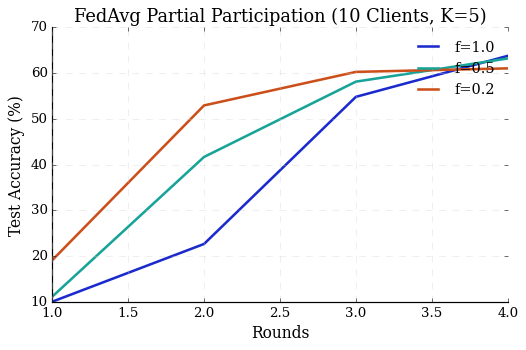

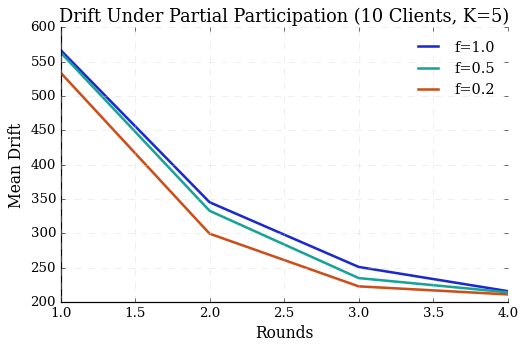

In [ ]:
fig, ax = plt.subplots()
for f in [1.0, 0.5, 0.2]:
    rounds = len(pp_results_10c[f][0])
    ax.plot(range(1, rounds+1), pp_results_10c[f][0], label=f"f={f}")
ax.set_xlabel("Rounds")
ax.set_ylabel("Test Accuracy (%)")
ax.set_title("FedAvg Partial Participation (10 Clients, K=5)")
ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(SAVE_PATH + "plots/fedavg_pp_10clients_accuracy.png", dpi=350, bbox_inches='tight')
fig.savefig(SAVE_PATH + "plots/fedavg_pp_10clients_accuracy.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
for f in [1.0, 0.5, 0.2]:
    rounds = len(pp_results_10c[f][1])
    ax.plot(range(1, rounds+1), pp_results_10c[f][1], label=f"f={f}")
ax.set_xlabel("Rounds")
ax.set_ylabel("Mean Drift")
ax.set_title("Drift Under Partial Participation (10 Clients, K=5)")
ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(SAVE_PATH + "plots/fedavg_pp_10clients_drift.png", dpi=350, bbox_inches='tight')
fig.savefig(SAVE_PATH + "plots/fedavg_pp_10clients_drift.pdf", bbox_inches='tight')
plt.show()


In [ ]:
with open(SAVE_PATH + "results_partial_participation_10clients.pkl", "wb") as f:
    pickle.dump(pp_results_10c, f)

for f_val in pp_results_10c:
    accs, drifts, regrets = pp_results_10c[f_val]
    df = pd.DataFrame({
        "Round": list(range(1, len(accs)+1)),
        "Accuracy": accs,
        "Drift": drifts,
        "Regret": regrets
    })
    df.to_csv(SAVE_PATH + f"results_pp_10clients_f{f_val}.csv", index=False)

print(" Saved metrics for 10-client partial participation to Drive.")


 Saved metrics for 10-client partial participation to Drive.


In [ ]:
class ClientProx:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def train_local(self, global_model, local_epochs, mu):
        model = copy.deepcopy(global_model).to('cuda')
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        # freeze a copy of global weights for proximal term
        global_state = {k: v.detach().clone() for k, v in global_model.state_dict().items()}

        for _ in range(local_epochs):
            for x, y in self.dataloader:
                x, y = x.cuda(), y.cuda()
                optimizer.zero_grad()

                logits = model(x)
                loss = criterion(logits, y)

                # proximal term
                prox = 0.0
                for (name, param) in model.named_parameters():
                    prox += ((param - global_state[name]) ** 2).sum()
                loss = loss + (mu / 2.0) * prox

                loss.backward()
                optimizer.step()

        return model


In [ ]:
num_clients = 5
data_per_client = len(trainset) // num_clients
client_indices = [list(range(i * data_per_client, (i+1) * data_per_client)) for i in range(num_clients)]
client_loaders = [DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True) for idxs in client_indices]
clients = [ClientProx(loader) for loader in client_loaders]

print(" FedProx clients initialized (IID, 5 clients)")


 FedProx clients initialized (IID, 5 clients)


In [ ]:
def run_fedprox(K, mu):
    global_model = init_model()
    running_min = 1e9

    total_epochs = 20
    rounds = total_epochs // K

    print(f"\n===== FedProx | K={K}, μ={mu} | {rounds} Rounds =====")
    accs, drifts, regrets = [], [], []

    for r in range(1, rounds+1):
        client_models = [c.train_local(global_model, K, mu) for c in clients]
        drift = compute_drift(global_model, client_models)
        global_model = aggregate(global_model, client_models)

        acc, loss = evaluate(global_model, test_loader)
        running_min = min(running_min, loss)
        regret = loss - running_min

        accs.append(acc)
        drifts.append(drift)
        regrets.append(regret)

        print(f"Round {r} | Acc={acc:.2f}% | Drift={drift:.3f} | Regret={regret:.4f}")
        torch.save(global_model.state_dict(), SAVE_PATH + f"fedprox_mu{mu}_round{r}.pt")

    return accs, drifts, regrets

fedprox_results = {}
for mu in [0.001, 0.01, 0.1]:
    fedprox_results[mu] = run_fedprox(K=5, mu=mu)



===== FedProx | K=5, μ=0.001 | 4 Rounds =====
Round 1 | Acc=11.37% | Drift=556.041 | Regret=0.0000
Round 2 | Acc=40.96% | Drift=346.749 | Regret=0.0000
Round 3 | Acc=65.46% | Drift=254.770 | Regret=0.0000
Round 4 | Acc=69.39% | Drift=211.802 | Regret=0.0446

===== FedProx | K=5, μ=0.01 | 4 Rounds =====
Round 1 | Acc=11.35% | Drift=456.636 | Regret=0.0000
Round 2 | Acc=33.48% | Drift=266.163 | Regret=0.0000
Round 3 | Acc=63.96% | Drift=223.722 | Regret=0.0000
Round 4 | Acc=69.96% | Drift=191.241 | Regret=0.0000

===== FedProx | K=5, μ=0.1 | 4 Rounds =====
Round 1 | Acc=15.59% | Drift=381.951 | Regret=0.0000
Round 2 | Acc=42.72% | Drift=176.874 | Regret=0.0000
Round 3 | Acc=52.88% | Drift=150.407 | Regret=0.0000
Round 4 | Acc=57.34% | Drift=127.226 | Regret=0.0000


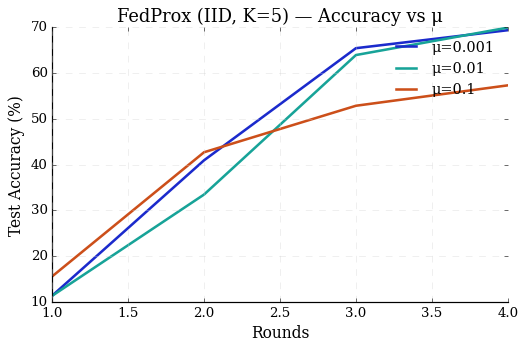

In [ ]:
fig, ax = plt.subplots()
for mu in fedprox_results:
    accs = fedprox_results[mu][0]
    ax.plot(range(1, len(accs)+1), accs, label=f"μ={mu}")
ax.set_xlabel("Rounds")
ax.set_ylabel("Test Accuracy (%)")
ax.set_title("FedProx (IID, K=5) — Accuracy vs μ")
ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(SAVE_PATH + "plots/fedprox_mu_accuracy.png", dpi=350, bbox_inches='tight')
plt.show()


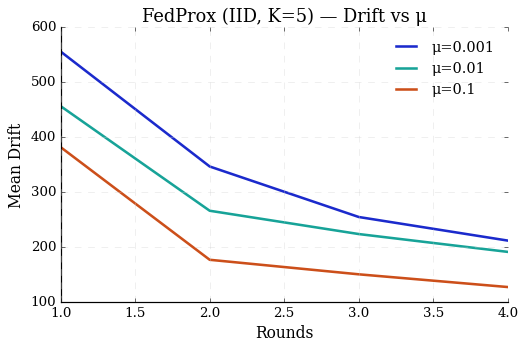

In [ ]:
fig, ax = plt.subplots()
for mu in fedprox_results:
    drifts = fedprox_results[mu][1]
    ax.plot(range(1, len(drifts)+1), drifts, label=f"μ={mu}")
ax.set_xlabel("Rounds")
ax.set_ylabel("Mean Drift")
ax.set_title("FedProx (IID, K=5) — Drift vs μ")
ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(SAVE_PATH + "plots/fedprox_mu_drift.png", dpi=350, bbox_inches='tight')
plt.show()


In [ ]:
def make_dirichlet_clients(alpha, num_clients=10):
    labels = np.array(trainset.targets)
    idxs_by_class = {c: np.where(labels == c)[0] for c in range(10)}

    client_indices = [[] for _ in range(num_clients)]
    for c in range(10):
        proportions = np.random.dirichlet([alpha] * num_clients)
        proportions = (proportions * len(idxs_by_class[c])).astype(int)
        split = np.split(np.random.permutation(idxs_by_class[c])[:sum(proportions)], np.cumsum(proportions[:-1]))
        for i in range(num_clients):
            client_indices[i].extend(split[i])

    loaders = [DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True) for idxs in client_indices]
    return [ClientProx(loader) for loader in loaders]


In [ ]:
alphas = [0.05, 0.2, 1, 100]
fedprox_alpha_results = {}

for alpha in alphas:
    clients = make_dirichlet_clients(alpha, num_clients=10)
    print(f"\n Dirichlet α={alpha}: new heterogeneous clients created.")
    fedprox_alpha_results[alpha] = run_fedprox(K=5, mu=0.01)



 Dirichlet α=0.05: new heterogeneous clients created.

===== FedProx | K=5, μ=0.01 | 4 Rounds =====
Round 1 | Acc=10.00% | Drift=417.977 | Regret=0.0000
Round 2 | Acc=15.50% | Drift=224.276 | Regret=0.0000
Round 3 | Acc=11.34% | Drift=207.613 | Regret=0.6045
Round 4 | Acc=23.34% | Drift=193.706 | Regret=0.0000

 Dirichlet α=0.2: new heterogeneous clients created.

===== FedProx | K=5, μ=0.01 | 4 Rounds =====
Round 1 | Acc=10.00% | Drift=10966.334 | Regret=0.0000
Round 2 | Acc=10.00% | Drift=13650.991 | Regret=0.0000
Round 3 | Acc=22.57% | Drift=4234.757 | Regret=0.0000
Round 4 | Acc=35.69% | Drift=816.059 | Regret=0.0000

 Dirichlet α=1: new heterogeneous clients created.

===== FedProx | K=5, μ=0.01 | 4 Rounds =====
Round 1 | Acc=10.78% | Drift=453.802 | Regret=0.0000
Round 2 | Acc=18.38% | Drift=260.951 | Regret=0.0000
Round 3 | Acc=47.07% | Drift=221.231 | Regret=0.0000
Round 4 | Acc=56.29% | Drift=188.347 | Regret=0.0000

 Dirichlet α=100: new heterogeneous clients created.

=====

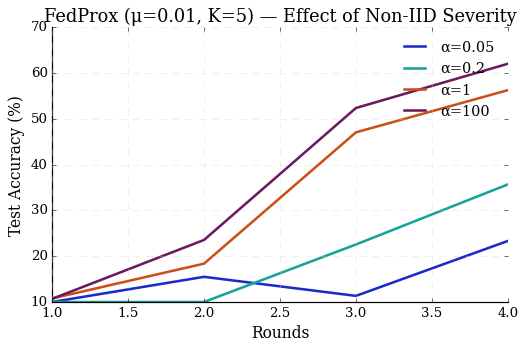

In [ ]:
fig, ax = plt.subplots()
for alpha in alphas:
    ax.plot(range(1, len(fedprox_alpha_results[alpha][0])+1),
            fedprox_alpha_results[alpha][0], label=f"α={alpha}")
ax.set_xlabel("Rounds")
ax.set_ylabel("Test Accuracy (%)")
ax.set_title("FedProx (μ=0.01, K=5) — Effect of Non-IID Severity")
ax = icml_axes(ax)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(SAVE_PATH + "plots/fedprox_alpha_accuracy.png", dpi=350, bbox_inches='tight')
plt.show()


In [ ]:
"/content/drive/MyDrive/fedavg/fedprox_ablation/"


'/content/drive/MyDrive/fedavg/fedprox_ablation/'

In [ ]:
ABLATE_PATH = SAVE_PATH + "fedprox_ablation/"
os.makedirs(ABLATE_PATH, exist_ok=True)


In [ ]:
def run_fedprox_ablation(alpha, mu_values, K=5):
    print(f"\n========== ABALATION FOR α={alpha} ==========")

    # new heterogeneous clients for this α
    clients = make_dirichlet_clients(alpha, num_clients=10)
    results_alpha = {}

    total_epochs = 10
    rounds = total_epochs // K

    for mu in mu_values:
        print(f"\n--- FedProx α={alpha}, μ={mu} ---")
        global_model = init_model()
        running_min = 1e9

        accs, drifts, regrets = [], [], []

        for r in range(1, rounds+1):
            client_models = [c.train_local(global_model, K, mu) for c in clients]
            drift = compute_drift(global_model, client_models)
            global_model = aggregate(global_model, client_models)
            acc, loss = evaluate(global_model, test_loader)

            running_min = min(running_min, loss)
            regret = loss - running_min

            accs.append(acc)
            drifts.append(drift)
            regrets.append(regret)

            print(f"Round {r} | Acc={acc:.2f}% | Drift={drift:.3f} | Regret={regret:.4f}")

            torch.save(global_model.state_dict(),
                       ABLATE_PATH + f"fedprox_alpha{alpha}_mu{mu}_round{r}.pt")

        results_alpha[mu] = (accs, drifts, regrets)

    # save metrics
    with open(ABLATE_PATH + f"fedprox_ablation_alpha{alpha}.pkl", "wb") as f:
        pickle.dump(results_alpha, f)

    return results_alpha


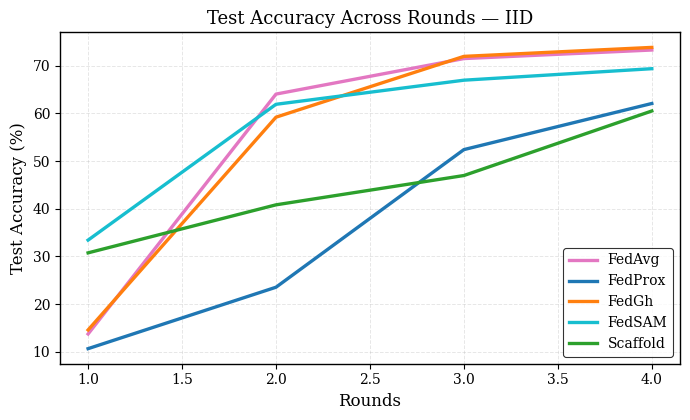

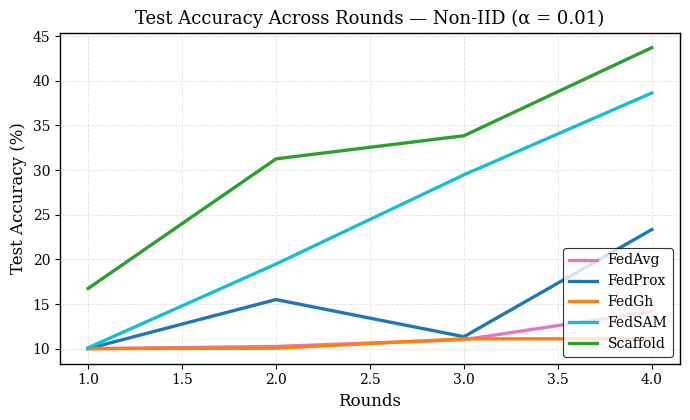

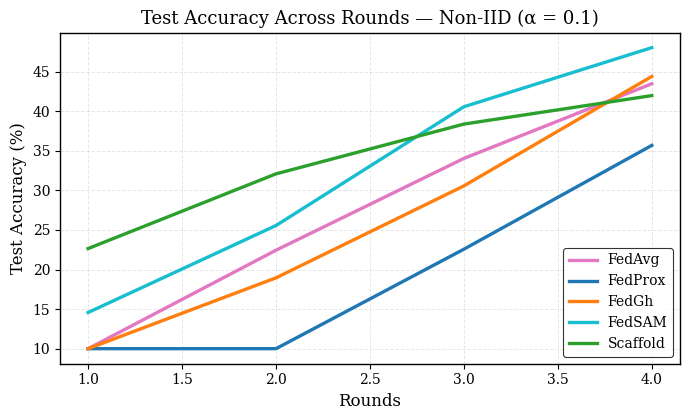

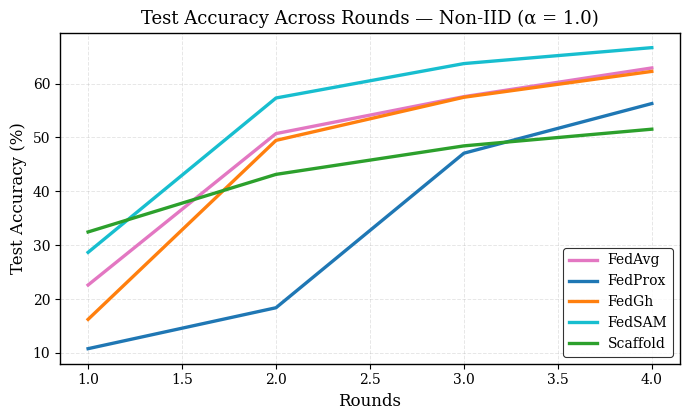

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# ==================== ICML-STYLE CONFIG ====================
mpl.rcParams.update({
    "text.usetex": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.8,
    "lines.linewidth": 2.4,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.figsize": (7.0, 4.3)
})

def icml_axes(ax):
    # Black framed box
    for side in ax.spines.values():
        side.set_linewidth(1.0)
        side.set_color("black")
    ax.grid(True)
    return ax

# ==================== DATA ====================

Rounds = [1, 2, 3, 4]

acc = {
    "FedAvg": {
        "IID":      [13.77, 64.02, 71.46, 73.25],
        "alpha=0.01":   [10.00, 10.25, 11.01, 14.16],
        "alpha=0.1":    [10.00, 22.44, 34.04, 43.48],
        "alpha=1.0":    [22.60, 50.71, 57.57, 62.90],
    },
    "FedProx": {
        "IID":      [10.69, 23.56, 52.39, 62.05],
        "alpha=0.01":   [10.00, 15.50, 11.34, 23.34],
        "alpha=0.1":    [10.00, 10.00, 22.57, 35.69],
        "alpha=1.0":    [10.78, 18.38, 47.07, 56.29],
    },
    "FedGh": {
        "IID":      [14.61, 59.18, 71.92, 73.80],
        "alpha=0.01":   [10.00, 10.05, 11.10, 11.11],
        "alpha=0.1":    [10.00, 18.95, 30.57, 44.40],
        "alpha=1.0":    [16.22, 49.45, 57.46, 62.26],
    },
    "FedSAM": {
        "IID":      [33.43, 61.88, 66.93, 69.34],
        "alpha=0.01":   [10.10, 19.48, 29.47, 38.64],
        "alpha=0.1":    [14.57, 25.56, 40.57, 48.04],
        "alpha=1.0":    [28.66, 57.32, 63.71, 66.67],
    },
    "Scaffold": {
        "IID":      [30.76, 40.82, 46.96, 60.48],
        "alpha=0.01":   [16.74, 31.26, 33.85, 43.72],
        "alpha=0.1":    [22.65, 32.09, 38.38, 41.98],
        "alpha=1.0":    [32.45, 43.14, 48.43, 51.53],
    }
}

Algorithms = list(acc.keys())

# ✔ 5-color balanced palette (NO duplicates)
colors = [
    "#e377c2",  # magenta — FedAvg
    "#1f77b4",  # blue — FedProx
    "#ff7f0e",  # rust — FedGh
    "#17becf",  # teal — FedSAM
    "#2ca02c",  # green — Scaffold
]

Conditions = [
    ("IID", "IID"),
    ("alpha=0.01", "Non-IID (α = 0.01)"),
    ("alpha=0.1",  "Non-IID (α = 0.1)"),
    ("alpha=1.0",  "Non-IID (α = 1.0)")
]

SAVE_PATH = "./"

# ==================== MAKE PLOTS ====================
for internal_key, display_label in Conditions:
    fig, ax = plt.subplots()

    ax.set_prop_cycle(color=colors)

    # Plot all 5 algorithms
    for algo in Algorithms:
        ax.plot(Rounds, acc[algo][internal_key], label=algo)

    ax.set_xlabel("Rounds")
    ax.set_ylabel("Test Accuracy (%)")
    ax.set_title(f"Test Accuracy Across Rounds — {display_label}")

    ax = icml_axes(ax)

    leg = ax.legend(frameon=True, loc="lower right")
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(0.8)

    fig.tight_layout()
    fig.savefig(SAVE_PATH + f"test_accuracy_{internal_key}.png", dpi=350, bbox_inches='tight')
    fig.savefig(SAVE_PATH + f"test_accuracy_{internal_key}.pdf", bbox_inches='tight')

    plt.show()


In [ ]:
mu_values = [0.001, 0.01, 0.1]

ablation_results = {}
for alpha in [0.05, 0.2, 1.0]:
    ablation_results[alpha] = run_fedprox_ablation(alpha, mu_values, K=5)



========== ABALATION FOR α=0.05 ==========

--- FedProx α=0.05, μ=0.001 ---
Round 1 | Acc=12.87% | Drift=464.806 | Regret=0.0000
Round 2 | Acc=10.00% | Drift=321.892 | Regret=0.0000

--- FedProx α=0.05, μ=0.01 ---
Round 1 | Acc=10.61% | Drift=423.580 | Regret=0.0000
Round 2 | Acc=10.16% | Drift=237.650 | Regret=0.0000

--- FedProx α=0.05, μ=0.1 ---
Round 1 | Acc=9.89% | Drift=363.681 | Regret=0.0000
Round 2 | Acc=11.03% | Drift=148.883 | Regret=0.0000

========== ABALATION FOR α=0.2 ==========

--- FedProx α=0.2, μ=0.001 ---
Round 1 | Acc=10.08% | Drift=630.882 | Regret=0.0000
Round 2 | Acc=12.39% | Drift=954.232 | Regret=0.0000

--- FedProx α=0.2, μ=0.01 ---
Round 1 | Acc=10.23% | Drift=615.126 | Regret=0.0000
Round 2 | Acc=12.57% | Drift=530.607 | Regret=0.0000

--- FedProx α=0.2, μ=0.1 ---
Round 1 | Acc=11.56% | Drift=572.685 | Regret=0.0000
Round 2 | Acc=17.58% | Drift=329.839 | Regret=0.0000

========== ABALATION FOR α=1.0 ==========

--- FedProx α=1.0, μ=0.001 ---
Round 1 | Acc=

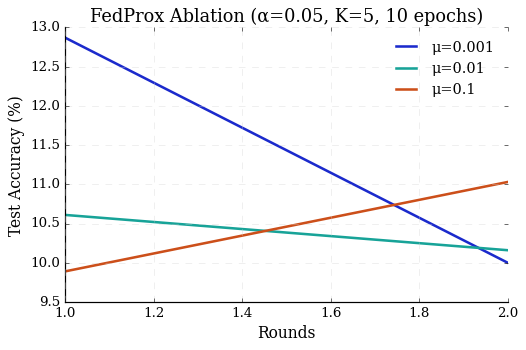

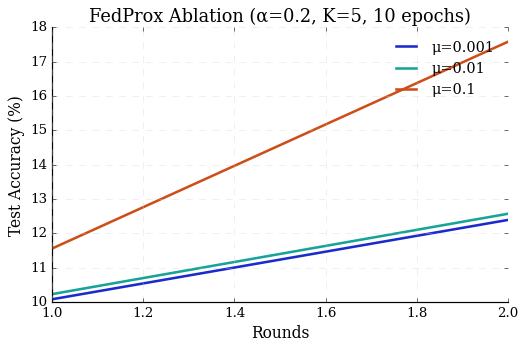

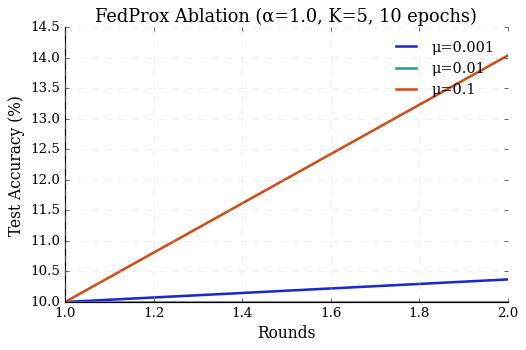

In [ ]:
for alpha in ablation_results:
    fig, ax = plt.subplots()
    for mu in ablation_results[alpha]:
        accs = ablation_results[alpha][mu][0]
        ax.plot(range(1, len(accs)+1), accs, label=f"μ={mu}")
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Test Accuracy (%)")
    ax.set_title(f"FedProx Ablation (α={alpha}, K=5, 10 epochs)")
    ax = icml_axes(ax)
    ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(ABLATE_PATH + f"fedprox_ablation_alpha{alpha}_accuracy.png", dpi=350, bbox_inches='tight')
    fig.savefig(ABLATE_PATH + f"fedprox_ablation_alpha{alpha}_accuracy.pdf", bbox_inches='tight')
    plt.show()
